In [2]:
!apt-get update
!apt-get install -y build-essential
!pip install pybind11
!python setup.py build_ext --inplace

Leyendo lista de paquetes... Hecho
E: No se pudo abrir el fichero de bloqueo «/var/lib/apt/lists/lock» - open (13: Permiso denegado)
E: No se pudo bloquear el directorio /var/lib/apt/lists/
W: Se produjo un problema al desligar el fichero /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permiso denegado)
W: Se produjo un problema al desligar el fichero /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permiso denegado)
E: No se pudo abrir el fichero de bloqueo «/var/lib/dpkg/lock-frontend» - open (13: Permiso denegado)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
running build_ext
building 'ReplayMemory' extension
creating build/temp.linux-x86_64-cpython-311
g++ -pthread -B /home/qwerty/anaconda3/envs/master/compiler_compat -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/qwerty/anaconda3/envs/master/include -fPIC -O2 -isystem /home/qwerty/anaconda3/envs/master/include -fPIC -I/home/qwerty/anaconda3/envs/master/lib/python3.11/site-packages

In [3]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque
import random
import copy
from tqdm import tqdm
import Rocket as r
import math
import ReplayMemory as rpm


device="cuda" if torch.cuda.is_available() else "gpu"


In [7]:
class Red(nn.Module):

    def __init__(self,il=4,hl=10,ol=2):

        super().__init__()

        self.network=nn.Sequential(nn.Linear(il,hl),
                                  nn.ReLU(),
                                  nn.Linear(hl,hl),
                                  nn.ReLU(),
                                  nn.Linear(hl,ol))
    def forward(self,x):
        return self.network(x)


In [8]:
class WrapAgent():

    def __init__(self,epsilon=0.7,decay=10):
        self.epsilon=epsilon
        self.decay=decay

        self.rng=np.random.default_rng(234343)


    def choose_action(self,env,state,repetition,Qnet,epsilon_o,step_epsilon,cont_epsilon):

        rand=self.rng.uniform(0,1)
        if(rand<(epsilon-step_epsilon*cont_epsilon) or rand<0.01):
            return env.sample()
        else:
            with torch.inference_mode():

                return torch.argmax(Qnet(torch.from_numpy(state).to(device).unsqueeze(dim=0).type(torch.float32))).detach().to("cpu").numpy()

In [ ]:
gamma=0.999
epsilon=1
decay=100
step_epsilon=0.005
cont_epsilon=0
tau=0.05
batch_size=128

start_train=100

max_steps=700
total_repetitions=100
episodes=4000

rp_len=3000

rp=rpm.ReplayMemory(rp_len,11)

agent=WrapAgent(epsilon,decay)


Qnet=Red(4,70,3).to(device)
target=Red(4,70,3).to(device)

target.load_state_dict(Qnet.state_dict())

optimizer=torch.optim.SGD(Qnet.parameters(),lr=3e-4)
loss=nn.MSELoss()
rng=np.random.default_rng(33234)
env=r.Rocket()

state_length=8


In [ ]:
rew=[]
t_steps=[]
error_t=[]



for i in range(episodes):

    #replay memory (s,r,a,s')



    with torch.inference_mode():
        reward=0
        time_steps=0

        #empiezo un episodio
        state=env.reset()

        for j in range(max_steps):

            action=agent.choose_action(env,state,i,Qnet,epsilon,step_epsilon,cont_epsilon)

            new=env.step(action)


            state_n=new[0:state_length+1]
            r=new[state_length+1]
            done=new[state_length+2]


            reward+=r
            time_steps+=1


            if(done==0):
                rp.append(
                    np.hstack((state,r,np.array(action),state_n,done))
                )
                break
            else:

                rp.append(
                    np.hstack((state,r,np.array(action),state_n,done))
                )

                state=state_n



    rew.append(reward)
    t_steps.append(time_steps)

    error=0

    
    if(i>=start_train):
        
        for iteracion in range(math.ceil(rp.len()/batch_size)):

            batch=rp.batch(batch_size)


            Qnet.train()

            #Estimo el q-value del estado con la red
            state=torch.from_numpy(batch[:,:state_length+1]).type(torch.float32).to(device)

            finish_states=torch.from_numpy(batch[:,-1]).type(torch.float32).unsqueeze(dim=0).to(device)
            sample_space=np.arange(4)


            actions=torch.vstack(
                tuple(
                    torch.from_numpy(sample_space==action_selected) for action_selected in batch[:,state_length+2]
                )
            ).to(device)


            q_values_qnet=Qnet(state)[actions].unsqueeze(dim=0)




            #Estimo el q_value del estado usando la ecuación de Bellman y la target net
            state_n=torch.from_numpy(batch[:,state_length+3:-1]).type(torch.float32).to(device)
            reward=torch.from_numpy(batch[:,state_length+1]).unsqueeze(dim=0).type(torch.float32).to(device)





            q_values_target=reward+gamma*torch.max(target(state_n),dim=1)[0]*finish_states


            err_train=loss(q_values_target,q_values_qnet)

            error+=(err_train.detach().to("cpu").numpy())


            optimizer.zero_grad()
            err_train.backward()

            optimizer.step()

            Qnet.eval()


        error_t.append(error)

        print(f"Process, {i*100/episodes:03.2f} %,  Episode {i:04d}, Steps {t_steps[-1]:03.0f}, Reward {rew[-1]:03.0f}, Error {error_t[-1]:09.5f}, Epsilon {epsilon-step_epsilon*cont_epsilon if epsilon-step_epsilon*cont_epsilon>0.01 else 0.01:03.3f}")

        if(i%1==0):
            #target.load_state_dict(Qnet.state_dict())

            Qnet_dict=Qnet.state_dict()
            target_dict=target.state_dict()

            for entrada in target_dict.keys():
                target_dict[entrada]=tau*Qnet_dict[entrada]+(1-tau)*target_dict[entrada]

            target.load_state_dict(target_dict)
            torch.save(Qnet.state_dict(),f="net.pth")

        cont_epsilon+=1

In [ ]:
torch.save(Qnet.state_dict(),f="net.pth")

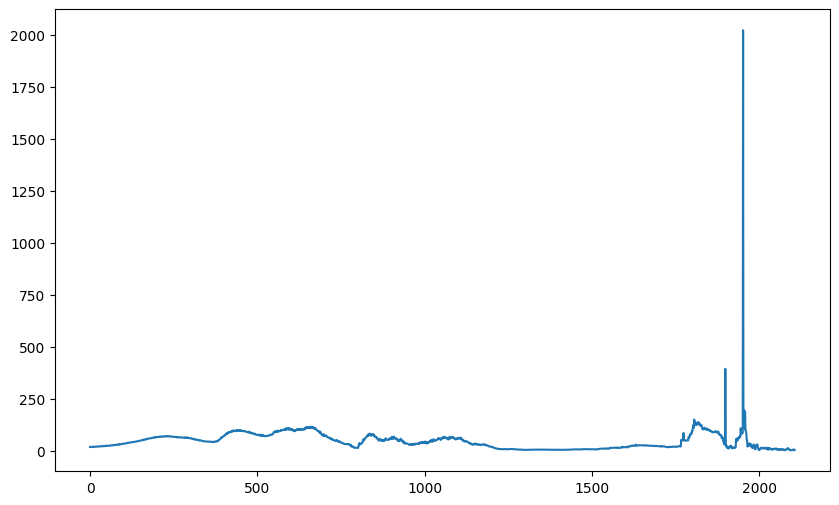

In [ ]:
plt.figure(1,figsize=(10,6))

plt.plot(np.arange(len(error_t)),error_t)

(array([490., 342., 187., 141., 133., 107.,  90.,  80.,  67.,  68.,  51.,
         37.,  40.,  29.,  19.,  25.,  15.,  17.,  14.,  12.,  16.,   7.,
          6.,   6.,   6.,   4.,   3.,   1.,   3.,   1.,   4.,   4.,   3.,
          1.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        164.]),
 array([  6.  ,  12.94,  19.88,  26.82,  33.76,  40.7 ,  47.64,  54.58,
         61.52,  68.46,  75.4 ,  82.34,  89.28,  96.22, 103.16, 110.1 ,
        117.04, 123.98, 130.92, 137.86, 144.8 , 151.74, 158.68, 165.62,
        172.56, 179.5 , 186.44, 193.38, 200.32, 207.26, 214.2 , 221.14,
        228.08, 235.02, 241.96

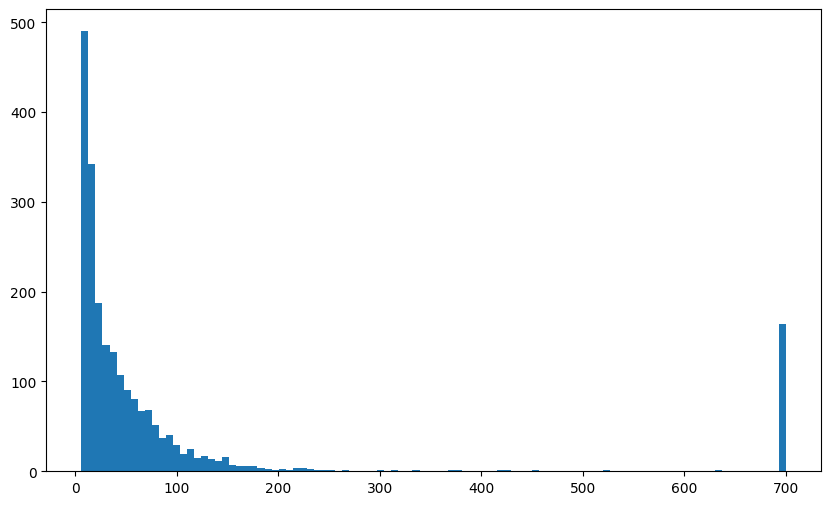

In [ ]:
plt.figure(1,figsize=(10,6))

plt.hist(t_steps,bins=100)

In [ ]:
#%matplotlib inline
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()

fig, ax = plt.subplots(figsize=(5,5))

state=env.reset()

def animate(t):

    ax.clear()
    xlim=10
    ylim=10
    plt.tight_layout()

    global state

    if(t==0):
      state=env.reset()

    action=Qnet(torch.from_numpy(state).unsqueeze(dim=1).to(device)).detach().to("cpu").squeeze().item()

    new=env.step(action)

    state=new[0:4]
    r=new[4]
    done=new[5]


    x_cm=state[0]
    theta=state[2]

    x_cm2=x_cm+2*np.sin(theta)
    y_cm2=2*np.cos(theta)


    #print((x_cm2-x_cm)**2+y_cm2**2)


    ax.set_ylim(-ylim,ylim)

    ax.set_xlim(-xlim,xlim)



    rect = Rectangle((x_cm-2, -0.25), width=4, height=0.5, edgecolor='blue', facecolor='lightblue')

    ax.add_patch(rect)

    ax.plot([x_cm,x_cm2],[0,y_cm2],color="brown",linewidth=4)

    #ax.scatter(x_cm,0,marker="o",color="red")

    #rect2 = Rectangle((x_cm2-3, y_cm2-0.1), width=6, height=0.2, facecolor='brown',rotation_point="center",angle=90-theta*180/np.pi)

    #ax.add_patch(rect2)
    #ax.scatter(x_cm2,y_cm2,marker="o",color="blue")

FuncAnimation(fig, animate, frames=900,interval=10)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float